In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import os
import sys

sys.path.insert(0, os.path.abspath("../../.."))

In [51]:
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# Database
from simpa.src.db import PostgresDB
from simpa.src.schemas import Proband
from simpa.src.cohorts import Cohort

# Clustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation

# Plotting matrix
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from simpa.src.plotting import plot_endpoints_for_clusters
sns.color_palette()



[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [52]:
load_dotenv()

True

In [53]:
# CLUSTERING
N_CLUSTERS = 20
N_COMPONENTS = 2

In [54]:
db = PostgresDB(
    db_name=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD")
)

Connected to database


In [55]:
print(os.getcwd())

/Users/tillrostalski/Git/simpa/simpa/src/notebooks


In [56]:
PICKLE_PATH = "../scripts/TR1/sim_matrix.pickle"

In [57]:
sim_df = pd.read_pickle(PICKLE_PATH)

In [58]:
sim_df.tail()

,20715521,20025356,20457494,20383767,20078619,20609051,20322340,20260901,20027438,20187184,...,20578248,20654025,20238290,20084697,20676571,20146147,20537317,20697061,20269044,20631546
20146147,0.443812,0.329435,0.428545,0.268801,0.244525,0.497222,0.441856,0.256468,0.585593,0.292271,...,0.357974,0.258099,0.267965,0.408113,0.293233,1.000000,0.276517,0.323640,0.287448,0.387046
20537317,0.292075,0.291819,0.342014,0.189432,0.277609,0.272376,0.307962,0.443768,0.234997,0.215864,...,0.304670,0.245517,0.274306,0.285522,0.244879,0.276517,1.000000,0.214047,0.313943,0.277255
20697061,0.528236,0.441771,0.314289,0.323113,0.404206,0.503457,0.244606,0.374691,0.339891,0.456593,...,0.431603,0.372364,0.325778,0.354707,0.348397,0.323640,0.214047,1.000000,0.282301,0.558546
20269044,0.437236,0.356947,0.378055,0.423385,0.342500,0.321149,0.240126,0.417072,0.708174,0.305852,...,0.346766,0.253806,0.197504,0.325999,0.193676,0.287448,0.313943,0.282301,1.000000,0.279106
20631546,0.557514,0.528826,0.347739,0.351235,0.408196,0.457087,0.344457,0.443962,0.319110,0.404366,...,0.431090,0.392911,0.319903,0.335819,0.438467,0.387046,0.277255,0.558546,0.279106,1.000000


In [59]:
#sns.heatmap(sim_df, xticklabels=False, yticklabels=False ,cmap="YlGnBu", fmt=".2f")

In [60]:
#sns.clustermap(sim_df, annot=False, xticklabels=False, yticklabels=False, fmt=".2f", cmap="Blues")

In [61]:
# distance matrix for clustering
dist_df = np.subtract(1, sim_df)

In [62]:
# Sum_of_squared_distances = []
# K = range(1,20)
# for num_clusters in K :
#     kmeans = KMeans(n_clusters=num_clusters)
#     kmeans.fit(dist_df)
#     Sum_of_squared_distances.append(kmeans.inertia_)
# plt.plot(K,Sum_of_squared_distances,'bx-')
# plt.xlabel('Values of K') 
# plt.ylabel('Sum of squared distances/Inertia') 
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [63]:
# Clustering

spectral_cluster = SpectralClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", n_init=100
).fit(dist_df)
# agglomerative_cluster = AgglomerativeClustering(
#     n_clusters=N_CLUSTERS, metric="precomputed", linkage="average"
# ).fit(dist_df)
kmeans_cluster = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(dist_df)
# dbscan_cluster = DBSCAN(eps=0.5, min_samples=2).fit(dist_df)
affinity_cluster = AffinityPropagation().fit(dist_df)

clusters = [
    spectral_cluster,
    kmeans_cluster,
    affinity_cluster,
]

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [64]:
# mds = MDS(n_components=N_COMPONENTS, dissimilarity="precomputed", random_state=1)
# mds_pos = mds.fit_transform(dist_df)

# pca = PCA(n_components=N_COMPONENTS)
# pca_pos = pca.fit_transform(dist_df)

tsne = TSNE(n_components=N_COMPONENTS)
tsne_pos = tsne.fit_transform(dist_df)

manifold_methods = ["mds", "pca", "tsne"]
manifold_poss = [tsne_pos]

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


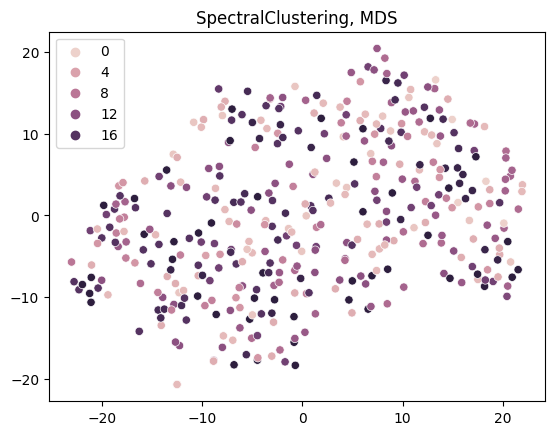

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


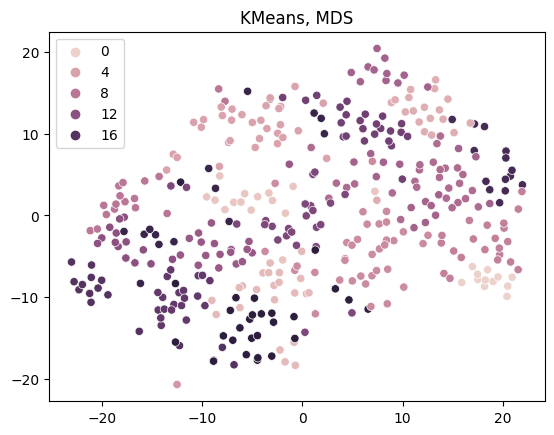

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


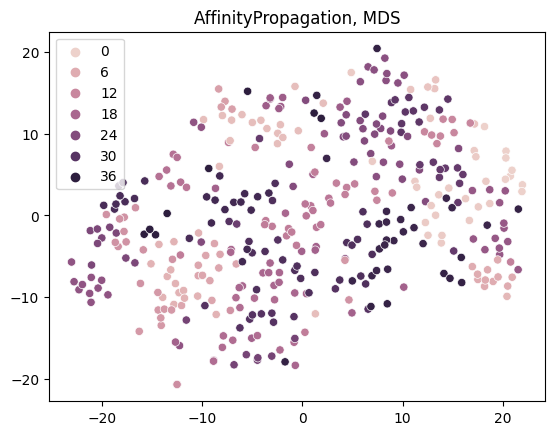

In [65]:
for cluster in clusters:
    for pos, method in zip(manifold_poss, manifold_methods):
        sns.scatterplot(x=pos[:, 0], y=pos[:, 1], hue=cluster.labels_, cmap="").set_title(
            f"{cluster.__class__.__name__}, {method.upper()}"
        )
        plt.show()

In [66]:
participants = [Proband(hadm_id=i) for i in dist_df.columns]
for p in participants:
    los_icu, los_hosp = db.get_endpoints_for_hadm_id(p.hadm_id)
    p.los_icu = los_icu
    p.los_hosp = los_hosp

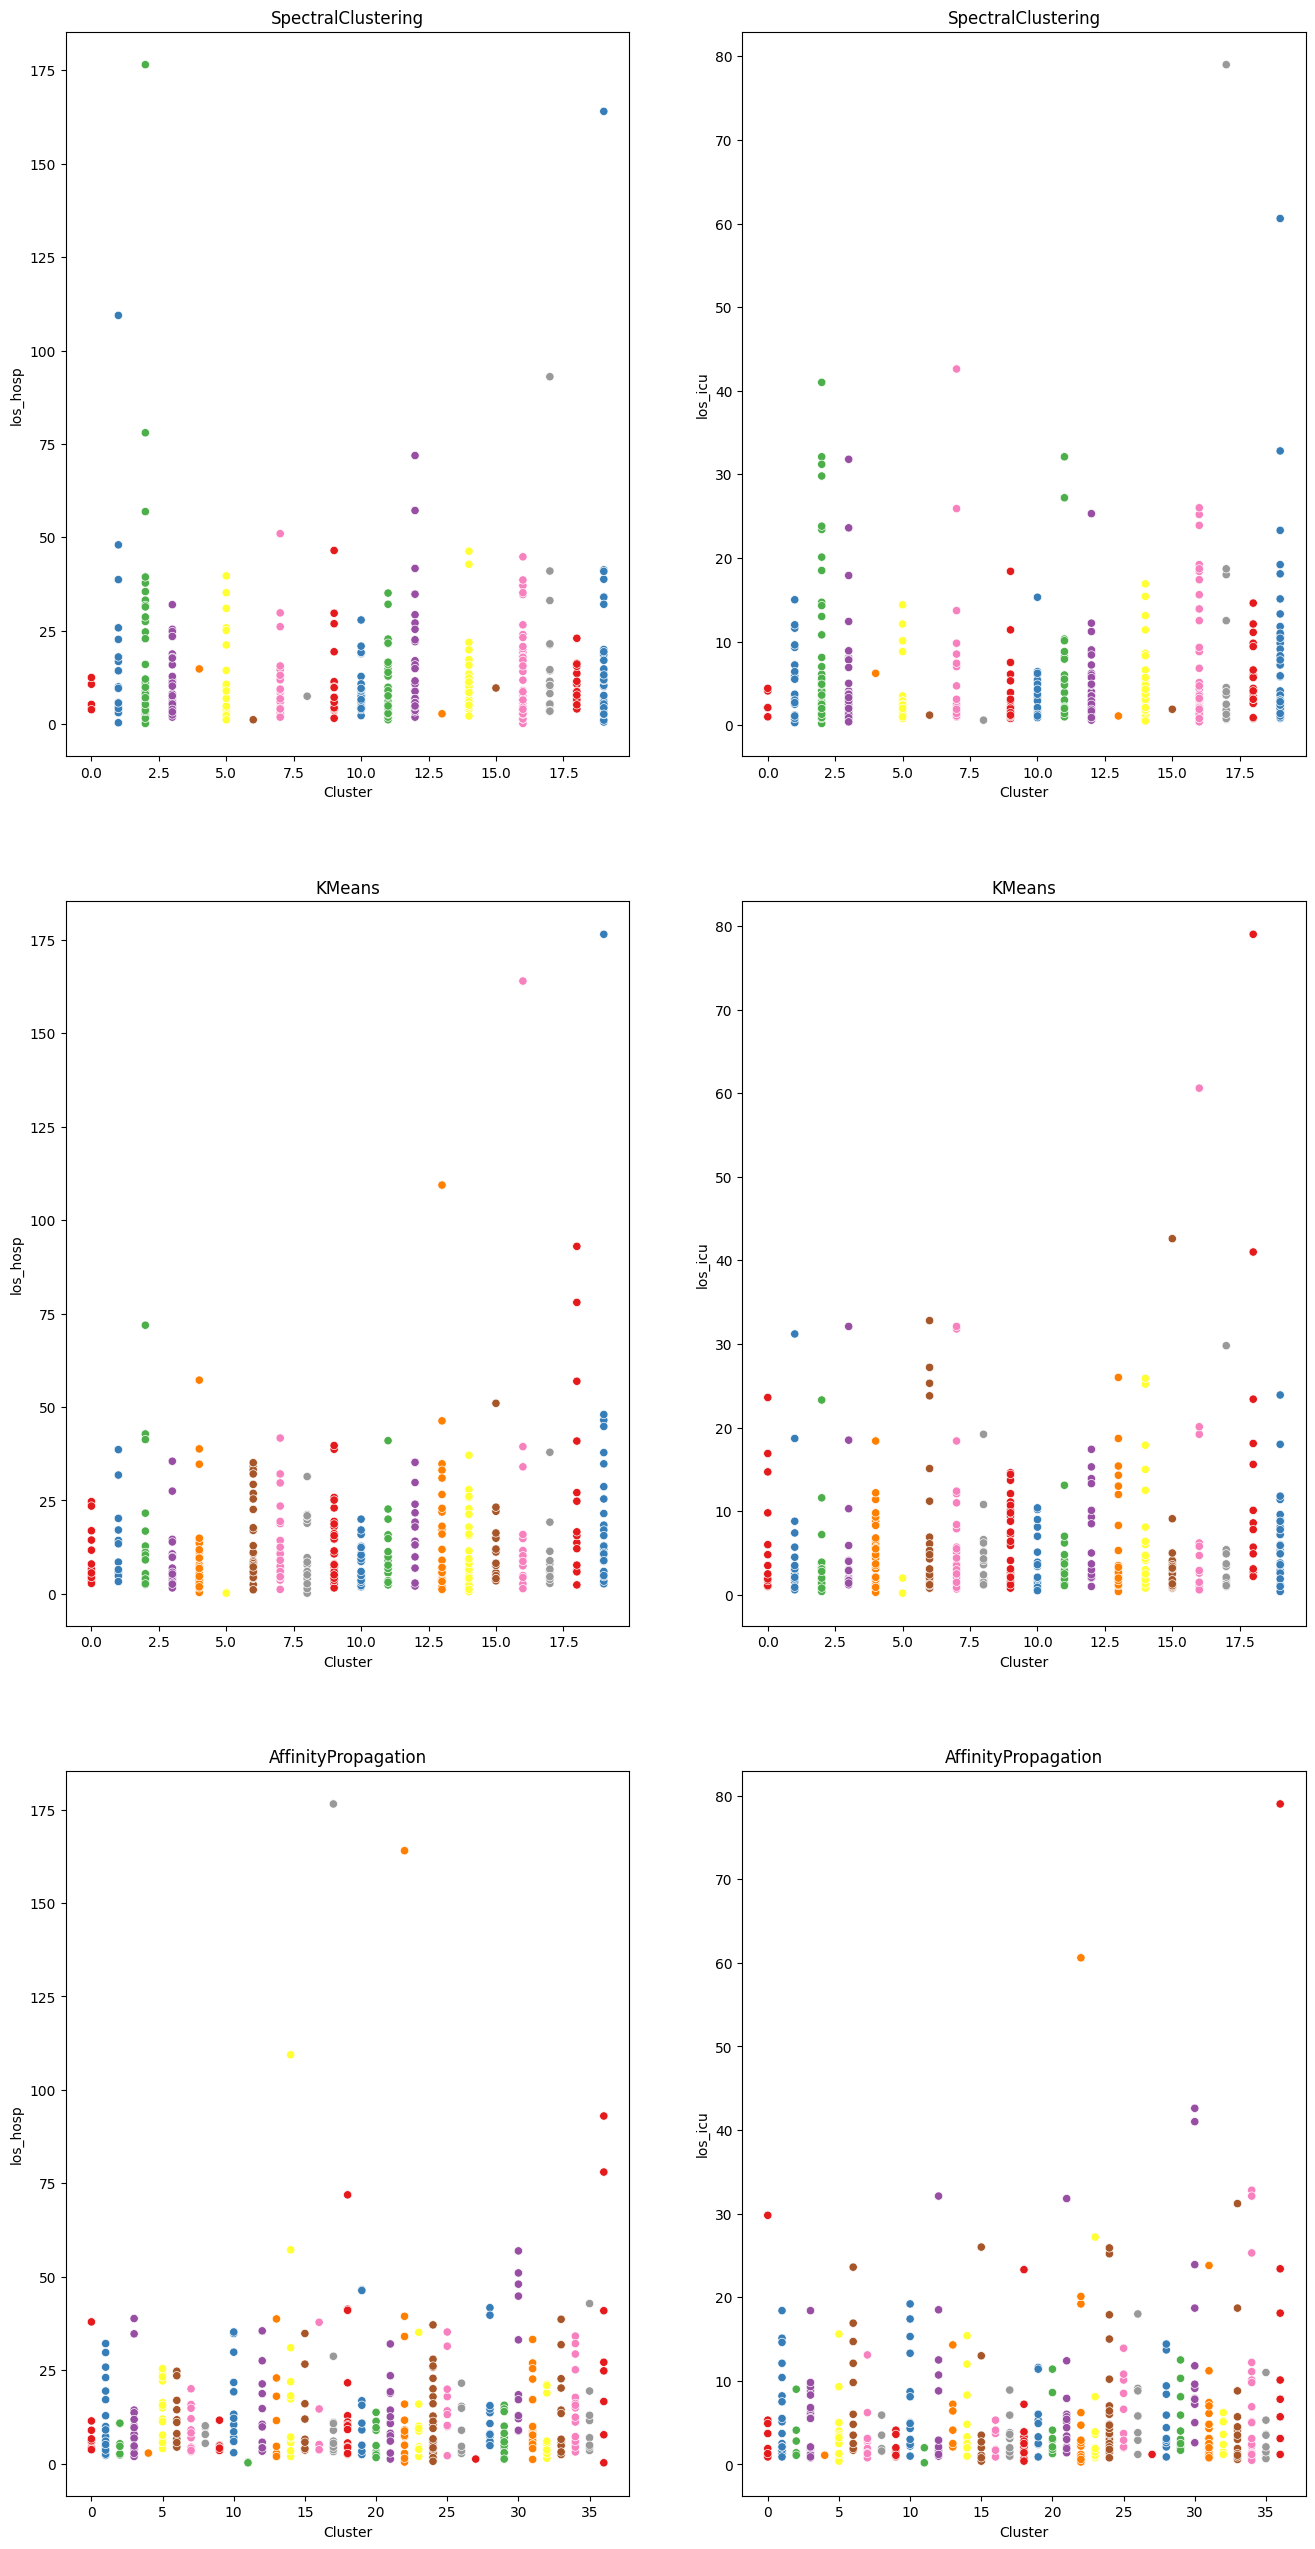

In [67]:
plot_endpoints_for_clusters(participants, clusters)

In [68]:
cluster_los_icu = {}
for cluster in clusters:
    cluster_los_icu[cluster.__class__.__name__] = {}
    for idx, label in enumerate(cluster.labels_):
        cluster_dict = cluster_los_icu[cluster.__class__.__name__]
        if not label in cluster_dict:
            cluster_dict[label] = []
        cluster_dict[label].append(participants[idx].los_icu)

In [69]:
clust_stats = {}
for k_i, v_i in cluster_los_icu.items():
    clust_stats[k_i] = {}
    for k, v in v_i.items():
        size = len(v)
        mean = np.mean(v)
        std = np.std(v)
        median = np.median(v)
        q1 = np.quantile(v, 0.25)
        q3 = np.quantile(v, 0.75)
        clust_stats[k_i][k] = {
            "mean": mean,
            "std": std,
            "median": median,
            "q1": q1,
            "q3": q3,
            "size": size,
        }
    clust_stats[k_i] = sorted(clust_stats[k_i].items(), key=lambda x: x[1]["median"])


In [70]:
clust_stats[spectral_cluster.__class__.__name__]

[(8,
  {'mean': 0.6, 'std': 0.0, 'median': 0.6, 'q1': 0.6, 'q3': 0.6, 'size': 1}),
 (13,
  {'mean': 1.1, 'std': 0.0, 'median': 1.1, 'q1': 1.1, 'q3': 1.1, 'size': 1}),
 (6,
  {'mean': 1.2, 'std': 0.0, 'median': 1.2, 'q1': 1.2, 'q3': 1.2, 'size': 1}),
 (15,
  {'mean': 1.9, 'std': 0.0, 'median': 1.9, 'q1': 1.9, 'q3': 1.9, 'size': 1}),
 (0,
  {'mean': 2.7399999999999998,
   'std': 1.3001538370516006,
   'median': 2.1,
   'q1': 2.1,
   'q3': 4.1,
   'size': 5}),
 (9,
  {'mean': 4.235294117647058,
   'std': 4.473706342945027,
   'median': 2.2,
   'q1': 1.5,
   'q3': 5.3,
   'size': 17}),
 (17,
  {'mean': 8.185,
   'std': 17.078122701280723,
   'median': 2.25,
   'q1': 1.5250000000000001,
   'q3': 4.125,
   'size': 20}),
 (7,
  {'mean': 6.141666666666667,
   'std': 9.391792368280344,
   'median': 2.25,
   'q1': 1.375,
   'q3': 7.1,
   'size': 24}),
 (5,
  {'mean': 4.415789473684211,
   'std': 4.1820749266985615,
   'median': 2.5,
   'q1': 1.5,
   'q3': 6.15,
   'size': 19}),
 (10,
  {'mean': 

In [71]:
def get_hadm_ids_for_cluster(cluster, cluster_label):
    return [p.hadm_id for p, label in zip(participants, cluster.labels_) if label == cluster_label]

In [72]:
h = get_hadm_ids_for_cluster(spectral_cluster, 6)
hl = db.get_mean_labevents(h)
print(hl)
hl = [l.dict() for l in hl]
hl_df = pd.DataFrame(hl)

ValueError: too many values to unpack (expected 8)

In [ ]:
hl_df.head()

,id,value,id_mean,id_std_dev,itemid,subject_id,hadm_id,valueuom,valuenum,label
0,50801,460.0,472.386794,125.878806,50801,14464839,20038242,mm Hg,None,Alveolar-arterial Gradient
1,50801,508.0,472.386794,125.878806,50801,18996386,20040940,mm Hg,None,Alveolar-arterial Gradient
2,50801,423.0,472.386794,125.878806,50801,13956197,20048588,mm Hg,None,Alveolar-arterial Gradient
3,50801,487.0,472.386794,125.878806,50801,10257550,20105129,mm Hg,None,Alveolar-arterial Gradient
4,50801,449.0,472.386794,125.878806,50801,10683325,20194161,mm Hg,None,Alveolar-arterial Gradient


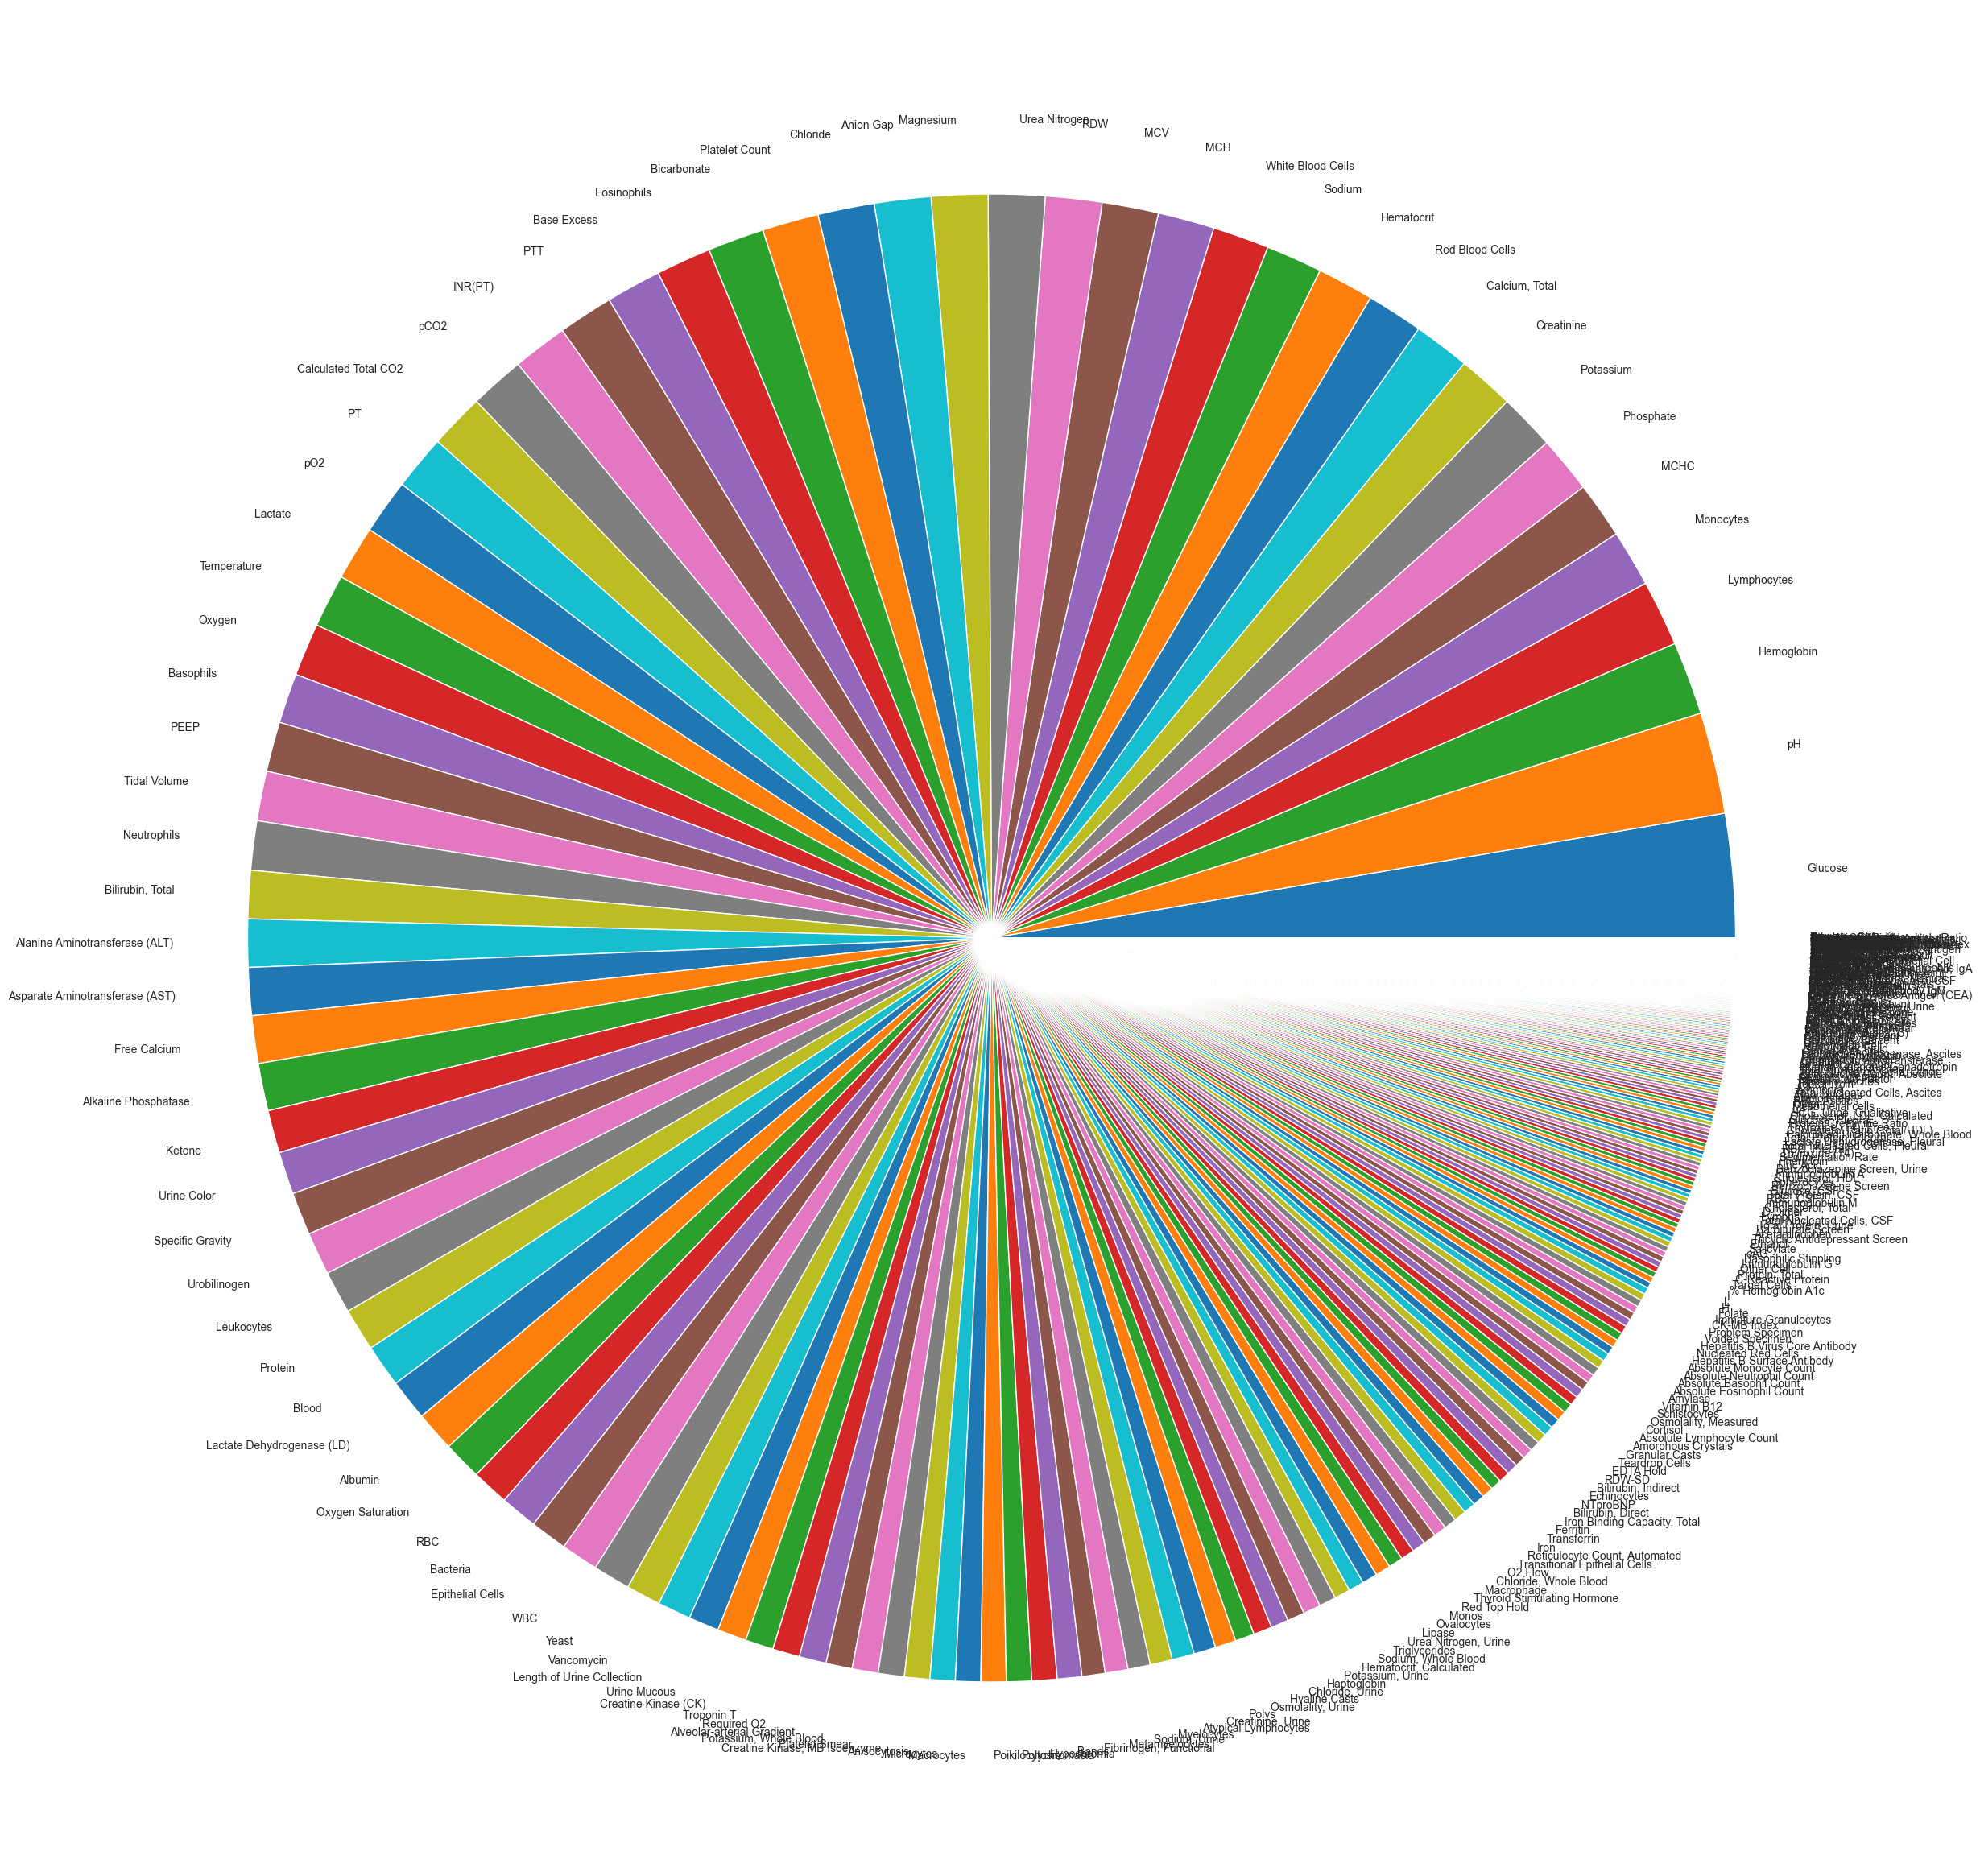

In [ ]:
# count of each id
hl_df["label"].value_counts()

# plot the counts in pie chart using seaborn, show counts in legend
sns.set_style("whitegrid")
plt.figure(figsize=(30,30))
plt.pie(hl_df["label"].value_counts(), labels=hl_df["label"].value_counts().index)
plt.show()